In [ ]:
!pip3 install gmpy2
!pip3 install tensorflow

     |████████████████████████████████| 3.6 MB 14.8 MB/s 
     |████████████████████████████████| 462 kB 10.4 MB/s 


In [ ]:
%matplotlib inline

import ctypes
import gmpy2
from gmpy2 import mpz
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import keras
import tensorflow as tf
from tensorflow.keras import layers
from keras import backend as K
from keras.models import Model
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense
from keras.layers import Flatten, Reshape
from keras.layers.convolutional import Conv1D
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.models import load_model

In [ ]:
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

m_train = (m_bits+ k_bits)

In [ ]:
K.clear_session()

##### Alice network #####
#
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)


alice_model = keras.Sequential(
    [
        layers.Dense(units=(m_bits + k_bits),activation="tanh"),
        layers.Reshape((m_bits + k_bits, 1,)),
        layers.Conv1D(filters=2, kernel_size=4, strides=1, padding=pad,activation="tanh"),
        layers.Conv1D(filters=4, kernel_size=2, strides=2, padding=pad,activation="tanh"),
        layers.Conv1D(filters=4, kernel_size=1, strides=1, padding=pad,activation="tanh"),
        layers.Conv1D(filters=1, kernel_size=1, strides=1, padding=pad,activation="sigmoid"),
        layers.Flatten(),
    ]
)
alice_model.compile(loss='mse', optimizer='sgd')
alice=alice_model(ainput)


##### Bob network #####
#
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bob_model = keras.Sequential(
    [
        layers.Dense(units=(c_bits + k_bits),activation="tanh"),
        layers.Reshape((c_bits + k_bits, 1,)),
        layers.Conv1D(filters=2, kernel_size=4, strides=1, padding=pad,activation="tanh"),
        layers.Conv1D(filters=4, kernel_size=2, strides=2, padding=pad,activation="tanh"),
        layers.Conv1D(filters=4, kernel_size=1, strides=1, padding=pad,activation="tanh"),
        layers.Conv1D(filters=1, kernel_size=1, strides=1, padding=pad,activation="sigmoid"),
        layers.Flatten(),
    ]
)
bob_model.compile(loss='mse', optimizer='sgd')
bob=bob_model(binput)
#bob.summary()


# Eve network
#
einput = Input(shape=(c_bits,)) #ciphertext only
eve1_model = keras.Sequential(
    [
        layers.Dense(units=(c_bits + k_bits),activation="tanh"),
        layers.Reshape((c_bits + k_bits, 1,)),
        layers.Conv1D(filters=2, kernel_size=4, strides=1, padding=pad,activation="tanh"),
        layers.Conv1D(filters=4, kernel_size=2, strides=2, padding=pad,activation="tanh"),
        layers.Conv1D(filters=4, kernel_size=1, strides=1, padding=pad,activation="tanh"),
        layers.Conv1D(filters=1, kernel_size=1, strides=1, padding=pad,activation="sigmoid"),
        layers.Flatten(),
    ]
)
eve1_model.compile(loss='mse', optimizer='sgd')
eve1=eve1_model(einput)
#eve.summary()

### Loss + Optimizer

In [ ]:
aliceout = alice_model(concatenate([ainput0, ainput1],axis=1))
bobout = bob_model( concatenate([aliceout, binput1], axis=1))
eveout = eve1_model(aliceout)

eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )


bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + (K.square(m_bits/2 - eveloss))/( (m_bits//2)**2 )

abeoptim = RMSprop(lr=0.001)
eveoptim = RMSprop(lr=0.001) 

abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)

alice_model.trainable = False
eve1_model = Model([ainput0, ainput1], eveout, name='evemodel')
eve1_model.add_loss(eveloss)
eve1_model.compile(optimizer=eveoptim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
abelosses = []
boblosses = []
evelosses = []

In [ ]:
epoch_count = 20
batch_size = 512
n_batches = 128

abecycles = 1
evecycles = 2

print("Training ", epoch_count, "epochs using", n_batches, "batches of size", batch_size)
print("------------------------------------------------")
for epoch in range(1,epoch_count):
    abe_losses = []
    bob_losses = []
    eve1_losses = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice_model.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch,k_batch], None)
            abe_losses.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abe_losses)

        ainp=concatenate([m_batch, k_batch], axis=1)
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice_model.predict(ainp)
        #print(type(m_enc),type(k_batch))
        binp=concatenate([m_enc,tf.cast(k_batch,tf.float64)],axis=1)  
        m_dec = bob_model.predict(binp)
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        bob_losses.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(bob_losses)
        
        # Train the EVE network
        #
        alice_model.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = eve1_model.train_on_batch([m_batch, k_batch], None)
            eve1_losses.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(eve1_losses)
       
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(epoch, 100 * iteration // n_batches, abeavg, eveavg,bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training  20 epochs using 128 batches of size 512
------------------------------------------------
Epoch   1:  99% | abe: 7.473 | eve: 7.853 | bob: 7.450
Epoch   2:  99% | abe: 4.660 | eve: 6.628 | bob: 4.584
Epoch   3:  99% | abe: 2.354 | eve: 4.696 | bob: 2.142
Epoch   4:  99% | abe: 1.274 | eve: 2.982 | bob: 0.852
Epoch   5:  99% | abe: 0.959 | eve: 2.048 | bob: 0.387
Epoch   6:  99% | abe: 0.771 | eve: 2.030 | bob: 0.198
Epoch   7:  99% | abe: 0.616 | eve: 2.518 | bob: 0.133
Epoch   8:  99% | abe: 0.527 | eve: 2.920 | bob: 0.107
Epoch   9:  99% | abe: 0.478 | eve: 3.202 | bob: 0.100
Epoch  10:  99% | abe: 0.442 | eve: 3.409 | bob: 0.097
Epoch  11:  99% | abe: 0.427 | eve: 3.576 | bob: 0.104
Epoch  12:  99% | abe: 0.400 | eve: 3.716 | bob: 0.098
Epoch  13:  99% | abe: 0.392 | eve: 3.837 | bob: 0.103
Epoch  14:  99% | abe: 0.372 | eve: 3.937 | bob: 0.101
Epoch  15:  99% | abe: 0.372 | eve: 4.002 | bob: 0.107
Epoch  16:  99% | abe: 0.363 | eve: 4.078 | bob: 0.110
Epoch  17:  99% | abe

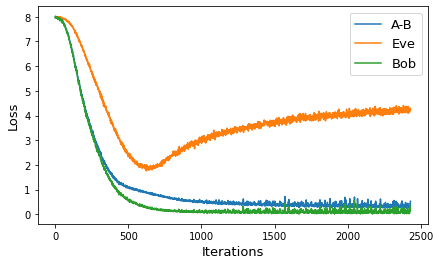

In [ ]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)

#plt.savefig("images/" + model_name + ".png", transparent=True) #dpi=100
plt.show()

In [ ]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
ainp=concatenate([m_batch,k_batch], axis=1)
m_enc = alice_model.predict(ainp)
m_dec = (bob_model.predict(concatenate([m_enc, tf.cast(k_batch,tf.float64)],axis=1)) > 0.5).astype(int)
m_att = (eve1_model.predict([m_enc,tf.cast(k_batch,tf.float64)]) > 0.5).astype(int)
bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  93.74 %
Eve % correct:  0.0 %


### Improvement of Eve

In [ ]:
alice_model.trainable = False

abelosses = []
boblosses = []
evelosses = []

In [ ]:
epoch_count = 20
batch_size = 512
n_batches = 128

abecycles = 1
evecycles = 2

print("Training ", epoch_count, "epochs using", n_batches, "batches of size", batch_size)
print("------------------------------------------------")
for epoch in range(1,epoch_count):
    abe_losses = []
    bob_losses = []
    eve1_losses = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice_model.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch,k_batch], None)
            abe_losses.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abe_losses)

        ainp=concatenate([m_batch, k_batch], axis=1)
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice_model.predict(ainp)
        #print(type(m_enc),type(k_batch))
        binp=concatenate([m_enc,tf.cast(k_batch,tf.float64)],axis=1)  
        m_dec = bob_model.predict(binp)
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        bob_losses.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(bob_losses)
        
        # Train the EVE network
        #
        alice_model.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = eve1_model.train_on_batch([m_batch, k_batch], None)
            eve1_losses.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(eve1_losses)
        
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(epoch, 100 * iteration // n_batches, abeavg, eveavg,bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training  20 epochs using 128 batches of size 512
------------------------------------------------
Epoch   1:  99% | abe: 0.332 | eve: 4.277 | bob: 0.104
Epoch   2:  99% | abe: 0.325 | eve: 4.324 | bob: 0.100
Epoch   3:  99% | abe: 0.320 | eve: 4.358 | bob: 0.102
Epoch   4:  99% | abe: 0.311 | eve: 4.411 | bob: 0.100
Epoch   5:  99% | abe: 0.306 | eve: 4.443 | bob: 0.097
Epoch   6:  99% | abe: 0.295 | eve: 4.487 | bob: 0.095
Epoch   7:  99% | abe: 0.293 | eve: 4.537 | bob: 0.096
Epoch   8:  99% | abe: 0.292 | eve: 4.551 | bob: 0.099
Epoch   9:  99% | abe: 0.284 | eve: 4.586 | bob: 0.092
Epoch  10:  99% | abe: 0.279 | eve: 4.616 | bob: 0.090
Epoch  11:  99% | abe: 0.279 | eve: 4.640 | bob: 0.094
Epoch  12:  99% | abe: 0.270 | eve: 4.687 | bob: 0.090
Epoch  13:  99% | abe: 0.265 | eve: 4.679 | bob: 0.086
Epoch  14:  99% | abe: 0.264 | eve: 4.727 | bob: 0.088
Epoch  15:  99% | abe: 0.259 | eve: 4.748 | bob: 0.084
Epoch  16:  99% | abe: 0.258 | eve: 4.782 | bob: 0.089
Epoch  17:  99% | abe

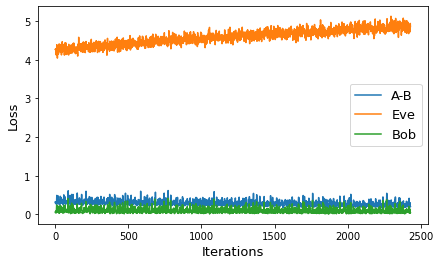

In [ ]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)

#plt.savefig("images/" + model_name + "-eve1.png", transparent=True) #dpi=100
plt.show()

In [ ]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
ainp=concatenate([m_batch,k_batch], axis=1)
m_enc = alice_model.predict(ainp)
m_dec = (bob_model.predict(concatenate([m_enc, tf.cast(k_batch,tf.float64)],axis=1)) > 0.5).astype(int)
m_att = (eve1_model.predict([m_enc,tf.cast(k_batch,tf.float64)]) > 0.5).astype(int)
bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  85.05 %
Eve % correct:  0.0 %
